<a href="https://colab.research.google.com/github/davidfague/Stylized-ReducedOrder-L5-Model/blob/main/NMDAExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.png" alt="Open In Colab"/></a>

In [130]:
Detailed=False # Change for whether or not you want to use the detailed or reduced order model
tstop=5000
dt=0.1

In [131]:
server=True #whether or not the folder is already in your directory
github=False # Change for whether or not you want to get the model from github or google drive
#Github isn't working right now because you need the data on Github, but the data is too large to upload.

save_dfs=False #Change for if you want to save the dataframes as csvs

import shutil
if server==True:
  print('Model should already be in directory.') #supports large data files in directory
elif github==True: # If you do not already have the model you can clone from Github; large data files are not stored on Github
  # shutil.rmtree('Stylized-ReducedOrder-L5-Model/') #removes folder if already cloned
  !git clone https://github.com/davidfague/Stylized-ReducedOrder-L5-Model.git
  %cd Stylized-ReducedOrder-L5-Model/
else: #If you have the folder in your google drive (easier to update geom_parameters), and allows uploading of large data files
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Stylized-ReducedOrder-L5-Model/
  tstop=1000

Model should already be in directory.


In [132]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns #there is not module named seaborn on the server, but it doesn't seem to be used
import scipy.signal as ss
import pdb
# import ZipFile

In [133]:
if Detailed == True:
  # output_folder = 'Detailedoutput_control' #no ina.h5
  output_folder = 'Detailedoutput'
  segs = pd.read_csv('DetailedSegments.csv')
  degrees_f='DetailedSegmentDegrees.csv'
  # ZipFile.extractall(path='Detailedoutput_control', members=None, pwd=None) #possible implementation for unzipping data from github
else:
  output_folder = 'output_control'+str(tstop)
  segs = pd.read_csv('ReducedSegments.csv')
  degrees_f='SegmentsDegrees.csv'

conns = pd.read_csv('./{}/Connections.csv'.format(output_folder))

In [134]:
def voltage_criterion(data=None, v_thresh=-40, time_thresh=260):
    threshold_crossings = np.diff(data > v_thresh, prepend=False)
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    # If length of threshold_crossings is not even
    if np.mod(np.argwhere(threshold_crossings).reshape(-1,).shape[0],2)!=0:
        legit_up_crossings = upward_crossings[:-1][np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
    else:
        legit_up_crossings = upward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
    return upward_crossings, legit_up_crossings, legit_down_crossings

# Input: upward and downward crossings
# Output: bounds of NMDA spikes meeting current criterion
def current_criterion(legit_uc_iso=[], legit_dc_iso=[], p=1, control_inmda=np.array([1])):
    bounds = []
    sum_current = []
    

    for ind1 in np.arange(0,len(legit_uc_iso)):
        e1 = control_inmda[legit_uc_iso[ind1], p] #current @ up_crossing[ind1]
        #all the indices where current crosses 130% of e1
        x30 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.3*e1, prepend=False))
        #all the indices where current crosses 115% of e1
        x15 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.15*e1, prepend=False))
        
        if len(x30)>0:
        
            x15_copy = x15
            x30_copy = x30
            
            try:
                i = x30[0][0]
            except:
                import pdb; pdb.set_trace()
                
            n = 0
            
            
            while n==0:
                if len(np.sort(x15[x15>i]))!=0:
                    b1 = i
                    b2 = np.sort(x15[x15>i])[0]
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2,p])/10)
                else:
                    b1 = i
                    b2 = (legit_dc_iso[ind1]-legit_uc_iso[ind1])
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2,p])/10)
                    n=1
                
                x30_copy = x30_copy[x30_copy>legit_uc_iso[ind1]+b2]
                #import pdb; pdb.set_trace()
                
                if len(x30_copy)!=0:
                    i = x30_copy[x30_copy>b2][0]
                else:
                    n=1
    return bounds, sum_current


In [135]:
conns.head()

,Node ID,Distance,Conductance,Type,Name,Source Population,Release Probability
0,2,17.3125,0.013573,dend,L5PCtemplate[0].dend[1](0.22191836595450065),exc_stim,1.0
1,2,17.3125,0.114036,dend,L5PCtemplate[0].dend[1](0.148825692570405),exc_stim,1.0
2,8,49.0000,0.092948,dend,L5PCtemplate[0].dend[1](0.9905666079524836),exc_stim,1.0
3,6,36.8125,0.085514,dend,L5PCtemplate[0].dend[1](0.6939801895340107),exc_stim,1.0
4,6,36.8125,0.030317,dend,L5PCtemplate[0].dend[1](0.6483533687777879),exc_stim,1.0


In [136]:
conns.loc[conns.Type=='dend','Sec ID'] = conns.loc[conns.Type=='dend','Name'].apply(lambda x: int(x.split('dend[')[1].split(']')[0]))

In [137]:
conns.loc[conns.Type=='dend','Sec ID'] = conns.loc[conns.Type=='dend','Name'].apply(lambda x: int(x.split('dend[')[1].split(']')[0]))
conns.loc[conns.Type=='apic','Sec ID'] = conns.loc[conns.Type=='apic','Name'].apply(lambda x: int(x.split('apic[')[1].split(']')[0]))
conns.loc[conns.Type=='soma','Sec ID'] = conns.loc[conns.Type=='soma','Name'].apply(lambda x: int(x.split('soma[')[1].split(']')[0]))
conns.loc[conns.Type=='axon','Sec ID'] = conns.loc[conns.Type=='axon','Name'].apply(lambda x: int(x.split('axon[')[1].split(']')[0]))

conns['X'] = conns['Name'].apply(lambda x: float(x.split('(')[1].split(')')[0]))

conns.rename(columns={'Distance':'conns_Distance'},inplace=True)

conns['Sec ID'] = conns['Sec ID'].astype(int)
conns['X'] = conns['X'].astype(float)

In [138]:
# print(segs['segmentID'])

In [139]:
print(segs)

     segmentID  BMTK ID   Seg_L   Seg_diam        X          Type  Sec ID  \
0            0        0  20.000  20.000000  0.50000          soma       0   
1            1        1   4.875   1.295714  0.06250          dend       0   
2            2        1   4.875   1.295714  0.18750          dend       0   
3            3        1   4.875   1.295714  0.31250          dend       0   
4            4        1   4.875   1.295714  0.43750          dend       0   
..         ...      ...     ...        ...      ...           ...     ...   
983        983       36   5.000   1.600000  0.71875  passivebasal       3   
984        984       36   5.000   1.600000  0.78125  passivebasal       3   
985        985       36   5.000   1.600000  0.84375  passivebasal       3   
986        986       36   5.000   1.600000  0.90625  passivebasal       3   
987        987       36   5.000   1.600000  0.96875  passivebasal       3   

     Distance  Section_L  Section_diam  ...       Coord X    Coord Y  \
0  

In [140]:
try:
  segs_degrees = pd.read_csv(degrees_f).groupby(['Sec ID','Type'])['Degrees'].max().reset_index() #degrees_f is segment degrees .csv file
except:
  print('Segment Degrees Missing')
  
segs['segmentID'] = segs.index

try:
  segs = segs.set_index(['Type','Sec ID']).join(segs_degrees.set_index(['Type','Sec ID'])).reset_index()
except:
  print('Segment Degrees Missing')
segs['Sec ID'] = segs['Sec ID'].astype(int)
segs['X'] = segs['X'].astype(float)
segs['Elec_distanceQ'] = 'None'
segs['DistanceQ'] = 'None'

try:
  segs.loc[segs.Type=='dend','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='dend','Elec_distance'], 10, labels=False, duplicates = 'drop')
  segs.loc[segs.Type=='apic','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='apic','Elec_distance'], 10, labels=False, duplicates = 'drop')
  segs.loc[segs.Type=='dend','DistanceQ'] = pd.qcut(segs.loc[segs.Type=='dend','Distance'], 10, labels=False, duplicates = 'drop')
  segs.loc[segs.Type=='apic','DistanceQ'] = pd.qcut(segs.loc[segs.Type=='apic','Distance'], 10, labels=False, duplicates = 'drop')
except:
  print('Elec_distance missing')

Segment Degrees Missing


In [141]:
print(segs)

     segmentID  BMTK ID   Seg_L   Seg_diam        X          Type  Sec ID  \
0            0        0  20.000  20.000000  0.50000          soma       0   
1            1        1   4.875   1.295714  0.06250          dend       0   
2            2        1   4.875   1.295714  0.18750          dend       0   
3            3        1   4.875   1.295714  0.31250          dend       0   
4            4        1   4.875   1.295714  0.43750          dend       0   
..         ...      ...     ...        ...      ...           ...     ...   
983        983       36   5.000   1.600000  0.71875  passivebasal       3   
984        984       36   5.000   1.600000  0.78125  passivebasal       3   
985        985       36   5.000   1.600000  0.84375  passivebasal       3   
986        986       36   5.000   1.600000  0.90625  passivebasal       3   
987        987       36   5.000   1.600000  0.96875  passivebasal       3   

     Distance  Section_L  Section_diam  ...    Coord Z  ParentSegID  \
0   

In [142]:
# #connections.csv may need improvement
# exc_syns_per_seg = conns[conns['Source Population']=='exc_stim'].groupby(['Type','Sec ID','X'])['Conductance'].count().reset_index().rename(columns={'Conductance':'num_syns'})
# inh_conns = conns[(conns['Source Population']=='dist_inh_stim')|
#                   (conns['Source Population']=='prox_inh_stim')].sort_values(by=['Type','Sec ID','X']).reset_index(drop=True)
# inh_syns_per_seg = inh_conns.groupby(['Type','Sec ID','X'])['Conductance'].count().reset_index().rename(columns={'Conductance':'num_syns'})

# segs['segmentID'] = segs.groupby(['Type','Sec ID']).cumcount()+1 #* alters segmentIDs

# exc_syns_per_seg['segmentID'] = exc_syns_per_seg.groupby(['Type','Sec ID']).cumcount()+1
# inh_syns_per_seg['segmentID'] = inh_syns_per_seg.groupby(['Type','Sec ID']).cumcount()+1

# exc_syns = segs.set_index(['Type','Sec ID','segmentID']).join(exc_syns_per_seg[['Type','Sec ID','segmentID','num_syns']].set_index(['Type','Sec ID','segmentID'])).reset_index()
# inh_syns = segs.set_index(['Type','Sec ID','segmentID']).join(inh_syns_per_seg[['Type','Sec ID','segmentID','num_syns']].set_index(['Type','Sec ID','segmentID'])).reset_index()


In [143]:
# exc_syns_per_seg.head()

In [144]:
segs['segmentID'] = segs.groupby(['Type','Sec ID']).cumcount()+1

In [145]:
# exc_syns_per_seg['segmentID'] = exc_syns_per_seg.groupby(['Type','Sec ID']).cumcount()+1

In [146]:
# exc_syns = segs.set_index(['Type','Sec ID','segmentID']).join(exc_syns_per_seg[['Type','Sec ID','segmentID','num_syns']].set_index(['Type','Sec ID','segmentID'])).reset_index()


In [147]:
v = h5py.File('./{}/v_report.h5'.format(output_folder),'r')
hva = h5py.File('./{}/Ca_HVA.ica_report.h5'.format(output_folder),'r')
lva = h5py.File('./{}/Ca_LVAst.ica_report.h5'.format(output_folder),'r')
ih = h5py.File('./{}/Ih.ihcn_report.h5'.format(output_folder),'r')

nmda = h5py.File('./{}/inmda_report.h5'.format(output_folder),'r')

na = h5py.File('./{}/NaTa_t.gNaTa_t_report.h5'.format(output_folder),'r')
ina = h5py.File('./{}/NaTa_t.ina_report.h5'.format(output_folder),'r')

spks = h5py.File('./{}/spikes.h5'.format(output_folder),'r')


#v['report']['biophysical']['data'][:]

In [148]:
v_thresh = -40 #initial v_thresh
v_thresh = -40
np.diff(v['report']['biophysical']['data'][:-10000,1]> v_thresh, prepend=False)

array([False, False, False, ..., False, False, False])

In [149]:
spktimes = spks['spikes']['biophysical']['timestamps'][:]
spkinds = np.sort((spktimes*10).astype(int))

In [150]:
na_df = pd.DataFrame(columns=['segmentID','na_lower_bound'])
# na_df1 = pd.DataFrame(columns=['segmentID','na_lower_bound'])

for p in segs[(segs.Type=='dend')|(segs.Type=='apic')].index:
    #print(p)
    threshold_crossings = np.diff(na['report']['biophysical']['data'][:,p] > (0.003/1000), prepend=False) #*/1000?
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    # Only count if not within 2 ms after a somatic spike
    na_spks = [i for i in upward_crossings if ~np.any((i-spkinds>=-5) & (i-spkinds<50))]
    
    if len(na_spks)>0:
        # na_df1 = na_df1.append(pd.DataFrame({'segmentID':np.tile(p,len(na_spks)),
        #                                        'na_lower_bound':na_spks}))
        na_df = pd.concat([na_df,pd.DataFrame({'segmentID':np.tile(p,len(na_spks)), #allegedly this is the same as append
                                                'na_lower_bound':na_spks})],axis=0, join='outer')
    else:
        # na_df1 = na_df1.append(pd.DataFrame({'segmentID':p,
        #                                        'na_lower_bound':np.array([np.nan])}))
        na_df = pd.concat([na_df,pd.DataFrame({'segmentID':p,
                                        'na_lower_bound':np.array([np.nan])})],axis=0, join='outer')

# print(na_df==na_df1)

In [151]:
if save_dfs==True:
    na_df.to_csv(output_folder+'/'+'na_df.csv')
    na_df = pd.read_csv(output_folder+'/'+'na_df.csv')


def reshape_pad(v, fillval=np.nan):
    lens = np.array([len(item) for item in v])
    mask = lens[:,None] > np.arange(lens.max())
    out = np.full(mask.shape,fillval)
    out[mask] = np.concatenate(v)
    return out

In [152]:
# #* investigate
# # get the value of the conductance at the peak
# df = pd.DataFrame(columns=['segmentID','na_lower_bound','peak_value'])

# for s in na_df[~pd.isnull(na_df.na_lower_bound)].segmentID.unique():

#     inds = na_df[na_df.segmentID==s]['na_lower_bound'].astype(int).values
    
#     L = np.split(na['report']['biophysical']['data'][:,s], inds)
    
#     X = reshape_pad(L)
    
#     peak_vals = np.max(X[:,0:10], axis=1)
    
#     df = pd.concat((df,pd.DataFrame({'segmentID': s*np.ones((inds.shape[0],)).astype(int),
#                                      'na_lower_bound': inds, 
#                                      'peak_value': peak_vals[1:]})))

# df.head()
# df.groupby('segmentID')['peak_value'].mean().hist()
# df_gb = df.groupby('segmentID')['na_lower_bound'].count().sort_values().reset_index()
# outliers = df_gb[df_gb.na_lower_bound>1000]['segmentID'].values
# df_noout = df[(df.segmentID.isin(outliers))&(df.peak_value>0.006)]
# na_df_new = pd.concat((df_noout[['segmentID','na_lower_bound','peak_value']],
#                        na_df.loc[~na_df.segmentID.isin(outliers),['segmentID','na_lower_bound','peak_value']]))
# na_df_new.to_csv('na_df.csv',index=False)
 
# df.loc[df.segmentID==936,'peak_value'].hist(bins=np.arange(0.003,0.01,0.001))

In [153]:
na_df.na_lower_bound

0       686
1       891
2      2337
3      4324
4      5657
      ...  
72    48228
73    48890
74    49256
75    49696
76    49844
Name: na_lower_bound, Length: 30507, dtype: object

In [ ]:
# #could try to make this recursive in the case that the random choice fails

# for i in na_df.segmentID.unique():
#    seg = na_df.loc[i,'segmentID']
#    if not pd.isnull(na_df.loc[i,'na_lower_bound']):
#        spkt = int(na_df.loc[i,'na_lower_bound'])
#        trace = na['report']['biophysical']['data'][spkt-10:spkt+10,seg]
#        peak_value = np.max(trace)
#        half_peak = peak_value/2
#        duration = np.arange(0,20)[trace>half_peak] + spkt - 10
#        na_df.loc[i,'duration_low'] = duration[0]
#        na_df.loc[i,'duration_high'] = duration[-1]
#        na_df.loc[i,'peak_value'] = peak_value
#    else:
#        na_df.loc[i,'duration_low'] = np.nan
#        na_df.loc[i,'duration_high'] = np.nan
#        na_df.loc[i,'peak_value'] = np.nan
       
# na_df['duration'] = (na_df['duration_high'] - na_df['duration_low'] + 1)/10

for i in na_df.segmentID.unique():
    seg = na_df.loc[i,'segmentID']
    if not pd.isnull(na_df.loc[i,'na_lower_bound']):
        spkt = int(na_df.loc[i,'na_lower_bound'])
        trace = na['report']['biophysical']['data'][spkt-10:spkt+10,seg]
        peak_value = np.max(trace)
        half_peak = peak_value/2
        # duration = np.arange(0,20)[trace>half_peak] + spkt - 10 #gave occasional error
        duration = np.arange(0,len(trace))[trace>half_peak] + spkt - 10
        na_df.loc[i,'duration_low'] = duration[0]
        na_df.loc[i,'duration_high'] = duration[-1]
        na_df.loc[i,'peak_value'] = peak_value
    else:
        na_df.loc[i,'duration_low'] = np.nan
        na_df.loc[i,'duration_high'] = np.nan
        na_df.loc[i,'peak_value'] = np.nan

In [ ]:
# na_df['duration'] = (na_df['duration_high'] - na_df['duration_low'] + 1)/10

In [ ]:
segs_na_df = segs.join(na_df.set_index('segmentID')).reset_index()
# display(segs_na_df.Type.to_string())
# display(segs_na_df.Elec_distance.to_string())


na_df.head



#segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&(segs_na_df.Type=='apic')]

/home/drfrbc/miniconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


<bound method NDFrame.head of    segmentID na_lower_bound
0          1            686
1          1            891
2          1           2337
3          1           4324
4          1           5657
..       ...            ...
72       911          48228
73       911          48890
74       911          49256
75       911          49696
76       911          49844

[30507 rows x 2 columns]>

In [ ]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)

#print(na_df)

In [ ]:
def get_sta(segs_na_df, spktimes):
    na_dend = np.zeros((10,39,))
    na_apic = np.zeros((10,39,))
    
    edges_dend=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='dend')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    edges_apic=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='dend')&
                                     (segs_na_df.Distance>edges_dend[e])&
                                     (segs_na_df.Distance<=edges_dend[e+1])]['na_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_dend[e] += x2
                
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='apic')&
                                     (segs_na_df.Distance>edges_apic[e])&
                                     (segs_na_df.Distance<=edges_apic[e+1])]['na_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
    return na_dend, na_apic

In [ ]:
na_dend, na_apic = get_sta(segs_na_df, spktimes)
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))
na_dend_rand, na_apic_rand = get_sta(segs_na_df, rand_spktimes)

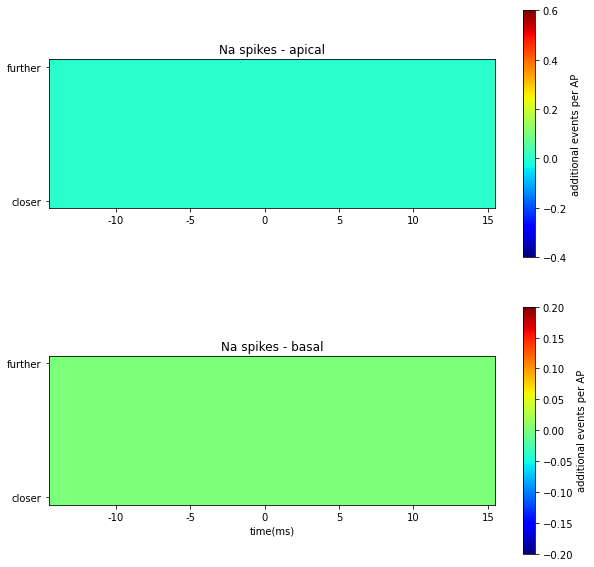

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Na spikes - apical')
plt.imshow((na_dend-na_dend_rand)/len(spktimes),cmap='jet',vmin=-0.4, vmax=0.6)
# plt.imshow((na_apic-na_apic_rand)/len(spktimes),cmap='jet')
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlim(5,35)

plt.subplot(2,1,2)
plt.title('Na spikes - basal')
plt.imshow((na_dend-na_dend_rand)/len(spktimes),cmap='jet',vmin=-0.2, vmax=0.2)
# plt.imshow((na_dend-na_dend_rand)/len(spktimes),cmap='jet')
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlabel('time(ms)')
plt.xlim(5,35)
if Detailed==True:
    plt.savefig(output_folder+'/DetailedNaSpikestoAP.png')
else:
    plt.savefig(output_folder+'/ReducedNaSpikestoAP.png')

plt.show()

----------

Reduced Order


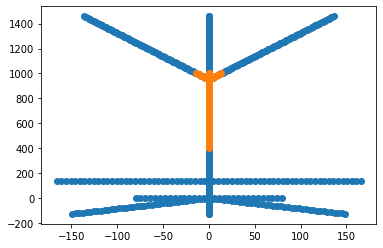

In [ ]:
if Detailed==True:
    print('Detailed')
    lowery=500
    uppery=700
    plt.scatter(segs['Coord X'], segs['Coord Y'])
    plt.scatter(segs.loc[(segs['Coord Y']>lowery) & (segs['Coord Y']<uppery),'Coord X'],
                segs.loc[(segs['Coord Y']>lowery) & (segs['Coord Y']<uppery),'Coord Y'])
else: # change segments considered
    print('Reduced Order')
    lowery=500
    uppery=700
    plt.scatter(segs['Coord X'], segs['Coord Y'])
    plt.scatter(segs.loc[(segs['Sec Name']=='disttrunk') | (segs['Sec Name']=='proxtuft') | ((segs['Sec Name']=='midtrunk') & (segs['Coord Y']>400)),'Coord X'],
                segs.loc[(segs['Sec Name']=='disttrunk') | (segs['Sec Name']=='proxtuft') | ((segs['Sec Name']=='midtrunk') & (segs['Coord Y']>400)),'Coord Y'])

In [ ]:
Dnexus=segs[((segs['Sec Name']=='disttrunk')&(segs['Elec_distance']>910)) | (segs['Sec Name']=='proxtuft')]
print(Dnexus['Elec_distance'].max())
print(Dnexus['Elec_distance'].min())

0.0786693614353749
0.0353620056207302


In [163]:
ca_df = pd.DataFrame(columns=['segmentID','ca_lower_bound'])

segs['segmentID'] = segs.index
if Detailed==True:
    CAsegIDs = segs[(segs.Type=='apic')&(segs['Coord Y']>lowery)&(segs['Coord Y']<uppery)]['segmentID']
else:
    CAsegIDs = segs[(segs['Sec Name']=='disttrunk') | (segs['Sec Name']=='proxtuft') | (segs['Sec Name']=='midtrunk')]['segmentID']
for p in CAsegIDs:
    trace = hva['report']['biophysical']['data'][:,p]+\
                lva['report']['biophysical']['data'][:,p]+\
                ih['report']['biophysical']['data'][:,p]
    m = np.mean(trace)
    s = np.std(trace)

    legit_uc = voltage_criterion(data=v['report']['biophysical']['data'][:,p],v_thresh=-40, time_thresh=200)[1]
    legit_dc = voltage_criterion(data=v['report']['biophysical']['data'][:,p],v_thresh=-40, time_thresh=200)[-1]
    
    legit_uc_iso = legit_uc
    
    legit_dc_iso = legit_dc

    
    
    if (len(legit_uc_iso)!=0) & (np.min(trace)!=0):
        bnds, sum_curr = current_criterion(legit_uc_iso=legit_uc_iso, 
                                           legit_dc_iso=legit_dc_iso, 
                                           p=p, 
                                           control_inmda=hva['report']['biophysical']['data'])
        ca_df = pd.concat([ca_df,pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
                                               'ca_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
                                               'ca_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
                                               'mag':sum_curr})],axis=0, join='outer')
    
    else:
        ca_df = pd.concat([ca_df,pd.DataFrame({'segmentID':np.tile(p,1),
                                               'ca_lower_bound':np.nan,
                                               'ca_upper_bound':np.nan,
                                               'mag':np.nan})],axis=0, join='outer')

In [164]:
#print(ca_df)

In [165]:
if save_dfs==True:
    ca_df.to_csv(output_folder+'/'+'ca_df.csv')
    ca_df = pd.read_csv(output_folder+'/'+'ca_df.csv')

# durations

In [166]:
np.random.choice(segs[(segs['Coord Y']<-50)&
     (segs['Coord Y']>-100)&
     (segs['Coord X']>-50)&
     (segs['Coord X']<50)&
     (segs['Type']=='dend')]['segmentID'])

102

## Plotting morphology as heat maps

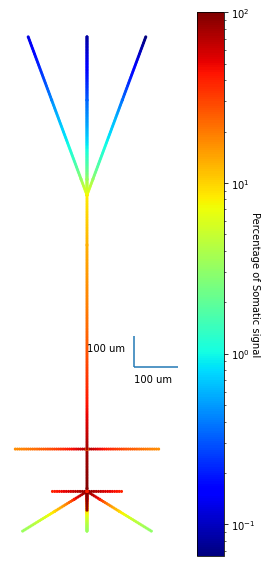

In [167]:
plt.figure(figsize=(4,10))
ax = plt.scatter(segs['Coord X'], segs['Coord Y'],c=100*segs['Elec_distance'],s=4,cmap='jet', norm='log')
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Percentage of Somatic signal', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('Elec_distance.png')

## Plotting morphology and voltage traces

In [168]:
# x = ca_df[~pd.isnull(ca_df.ca_lower_bound)].reset_index()
# i = np.random.choice(x.index)

In [169]:
ca_df.reset_index(inplace=True)

In [170]:
ca_df

,index,segmentID,ca_lower_bound,ca_upper_bound,mag
0,0,325,NaN,NaN,NaN
1,0,326,NaN,NaN,NaN
2,0,327,NaN,NaN,NaN
3,0,328,NaN,NaN,NaN
4,0,329,NaN,NaN,NaN
...,...,...,...,...,...
3059,15,531,29850,35903.0,-3.788585
3060,16,531,36065,39712.0,-2.819293
3061,17,531,39888,45396.0,-3.552387
3062,18,531,45539,48470.0,-1.781603


In [171]:
for i in np.random.choice(ca_df[(ca_df.ca_lower_bound>20) & (ca_df.ca_lower_bound<1400000)].index,100):
    seg = ca_df.loc[i,'segmentID']
    if not pd.isnull(ca_df.loc[i,'ca_lower_bound']):
        spkt = int(ca_df.loc[i,'ca_lower_bound'])
        if spkt>100:
          
          trace = -(hva['report']['biophysical']['data'][spkt-100:spkt+200,seg] + \
                  lva['report']['biophysical']['data'][spkt-100:spkt+200,seg] + \
                  ih['report']['biophysical']['data'][spkt-100:spkt+200,seg])
          try:
            peak_value = np.max(trace) # may recieve error here if trace is empty. in that case, check segmentID and seg
          except:
            pdb.set_trace()
          half_peak = peak_value/2
          duration = np.arange(0,300)[trace>half_peak] + spkt - 10
          ca_df.loc[i,'duration_low'] = duration[0]
          ca_df.loc[i,'duration_high'] = duration[-1]
          ca_df.loc[i,'peak_value'] = peak_value
    else:
        ca_df.loc[i,'duration_low'] = np.nan
        ca_df.loc[i,'duration_high'] = np.nan
        ca_df.loc[i,'peak_value'] = np.nan

----------

In [172]:
segs_ca_df = segs.set_index('segmentID').join(ca_df.set_index('segmentID')).reset_index() 

/home/drfrbc/miniconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [173]:
# segs_ca_df['logElec_distance']=np.log(segs_ca_df['Elec_distance'])

In [174]:
def get_ca_sta(segs_ca_df, spktimes):

    ca_apic = np.zeros((10,27,))
    
    edges_apic=np.quantile(segs_ca_df[(~pd.isnull(segs_ca_df.ca_lower_bound))&
                                       (segs_ca_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1)) #split apical segments into 10 groups with equally spaced electrotonic distance
    
    
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                ca_inds = segs_ca_df[(~pd.isnull(segs_ca_df.ca_lower_bound))&
                                     (segs_ca_df.Type=='apic')&
                                     (segs_ca_df.Elec_distance>edges_apic[e])&
                                     (segs_ca_df.Elec_distance<=edges_apic[e+1])]['ca_lower_bound'].values.astype(int) #get spikes within the electrotonic distance groups
    
                x2, _ = np.histogram(ca_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5)) #bin the spikes based on time
                ca_apic[e] += x2
                
                
            
            actual_spktimes.append(i)
        c = i
    return ca_apic

In [175]:
ca_apic = get_ca_sta(segs_ca_df, spktimes)

In [176]:
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))
ca_apic_rand = get_ca_sta(segs_ca_df, rand_spktimes)

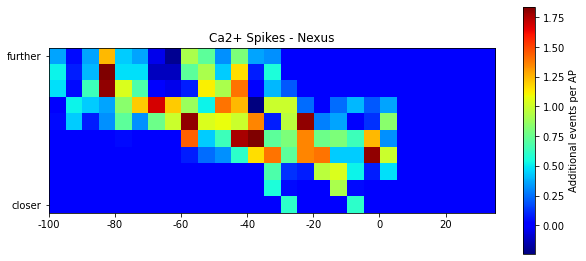

In [205]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Ca2+ Spikes - Nexus')
plt.imshow((ca_apic-ca_apic_rand)/len(spktimes),cmap='jet')
# plt.imshow((ca_apic-ca_apic_rand)/len(spktimes),cmap='jet',vmin=-1.5,vmax=1.5)
plt.imshow((ca_apic-ca_apic_rand)/len(spktimes),cmap='jet',vmin=None,vmax=None)
# plt.xticks(ticks=np.arange(0,40,2)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,2)])
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.colorbar(label='Additional events per AP')
# plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.yticks(ticks=[0,9],labels=['further','closer'])
if Detailed==True:
    plt.savefig(output_folder+'/DetailedCaSpikes.png')
else:
    plt.savefig(output_folder+'/ReducedCaSpikes.png')
plt.show()

----------------------

In [178]:
#apic_exc = segs_conns[(segs_conns['Source Population']=='exc_stim')&(segs_conns.Type=='apic')].groupby('segmentID')['Conductance'].sum().reset_index()

#basal_exc = segs_conns[(segs_conns['Source Population']=='exc_stim')&(segs_conns.Type=='dend')].groupby('segmentID')['Conductance'].sum().reset_index()


In [179]:
nmda_df = pd.DataFrame(columns=['segmentID','nmda_lower_bound', 'nmda_upper_bound', 'mag'])
for p in segs[(segs.Type=='dend')|(segs.Type=='apic')].index: #(segs.Type=='dend')|(segs.Type=='apic')
    #print(p)
    legit_uc = voltage_criterion(data=v['report']['biophysical']['data'][:,p],v_thresh=-40, time_thresh=260)[1]
    legit_dc = voltage_criterion(data=v['report']['biophysical']['data'][:,p],v_thresh=-40, time_thresh=260)[-1]
    
    legit_uc_iso = legit_uc
    
    legit_dc_iso = legit_dc

    #print(legit_uc)
    #print(legit_dc)
    
    if (len(legit_uc_iso)!=0) & (np.min(nmda['report']['biophysical']['data'][:,p])!=0):
        bnds, sum_curr = current_criterion(legit_uc_iso=legit_uc_iso, 
                                           legit_dc_iso=legit_dc_iso, 
                                           p=p, 
                                           control_inmda=nmda['report']['biophysical']['data'])


        # nmda_df = nmda_df.append(pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
        #                                        'nmda_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
        #                                        'nmda_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
        #                                        'mag':sum_curr}))
        nmda_df = pd.concat([nmda_df,pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
                                               'nmda_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
                                               'nmda_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
                                               'mag':sum_curr})],axis=0, join='outer')
        #print(nmda_df.mag)
    
    else:
        #print('else')
        # nmda_df = nmda_df.append(pd.DataFrame({'segmentID':np.tile(p,1),
        #                                        'nmda_lower_bound':np.nan,
        #                                        'nmda_upper_bound':np.nan,
        #                                        'mag':np.nan}))
        nmda_df = pd.concat([nmda_df,pd.DataFrame({'segmentID':np.tile(p,1),
                                               'nmda_lower_bound':np.nan,
                                               'nmda_upper_bound':np.nan,
                                               'mag':np.nan})],axis=0, join='outer')


#display(nmda_df.mag.to_string())


#min(nmda_df.mag)

In [180]:
nmda_df['duration'] = nmda_df['nmda_upper_bound'] - nmda_df['nmda_lower_bound']
if save_dfs==True:
    nmda_df.to_csv(output_folder+'/'+'nmda_df.csv')
    nmda_df = pd.read_csv(output_folder+'/'+'nmda_df.csv')

In [181]:
#mda_df.mag <= -0.000000001

In [182]:
#segs_nmda_df[:]

In [183]:
#nmda_df.rename(columns={'seg_id':'segmentID'},inplace=True)

In [184]:
segs_nmda_df = segs.join(nmda_df.set_index('segmentID')).reset_index()

/home/drfrbc/miniconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [185]:
segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                  (segs_nmda_df.Type=='dend')]

,index,segmentID,BMTK ID,Seg_L,Seg_diam,X,Type,Sec ID,Distance,Section_L,...,Sec Name,Degrees,num_syns_exc,num_syns_inh,Elec_distanceQ,DistanceQ,nmda_lower_bound,nmda_upper_bound,mag,duration
90,90,90,9,4.9,0.5078,0.475,dend,8,164.550007,98.000004,...,distbasal,3,3,1,2,7,36022,36073,-8.850542,51
93,93,93,9,4.9,0.5078,0.625,dend,8,179.250008,98.000004,...,distbasal,3,4,2,1,8,35882,36080,-302.479441,198
94,94,94,9,4.9,0.5078,0.675,dend,8,184.150008,98.000004,...,distbasal,3,5,1,1,8,35882,36081,-25.778099,199
96,96,96,9,4.9,0.5078,0.775,dend,8,193.950008,98.000004,...,distbasal,3,4,1,0,8,23492,23895,-664.49055,403
100,100,100,9,4.9,0.5078,0.975,dend,8,213.550009,98.000004,...,distbasal,3,6,1,0,9,37513,37526,-70.288228,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,159,159,12,4.9,0.5078,0.925,dend,11,208.650009,98.000004,...,distbasal,3,5,4,0,9,13982,14786,-536.001967,804
195,159,159,12,4.9,0.5078,0.925,dend,11,208.650009,98.000004,...,distbasal,3,5,4,0,9,46312,46651,-147.036832,339
196,160,160,12,4.9,0.5078,0.975,dend,11,213.550009,98.000004,...,distbasal,3,7,2,0,9,4492,4865,-253.761548,373
197,160,160,12,4.9,0.5078,0.975,dend,11,213.550009,98.000004,...,distbasal,3,7,2,0,9,14202,14786,-339.48573,584


In [186]:
#min(segs_nmda_df.mag)

In [187]:
#segs_nmda_df[(segs_nmda_df.mag<-0.0001)]

In [188]:
def get_nmda_sta(segs_nmda_df, spktimes):    
    nmda_dend = np.zeros((10,27,))
    nmda_apic = np.zeros((10,27,))
    
    edges_dend=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                  (segs_nmda_df.Type=='dend')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    edges_apic=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.00001)&
                                   (segs_nmda_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                     (segs_nmda_df.Type=='dend')&
                                     (segs_nmda_df.Elec_distance>edges_dend[e])&
                                     (segs_nmda_df.Elec_distance<=edges_dend[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_dend[e] += x2
                
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                     (segs_nmda_df.Type=='apic')&
                                     (segs_nmda_df.Elec_distance>edges_apic[e])&
                                     (segs_nmda_df.Elec_distance<=edges_apic[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
        
    return nmda_dend, nmda_apic

In [189]:
nmda_dend, nmda_apic = get_nmda_sta(segs_nmda_df, spktimes)

In [190]:
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))

In [191]:
nmda_dend_rand, nmda_apic_rand = get_nmda_sta(segs_nmda_df, rand_spktimes)

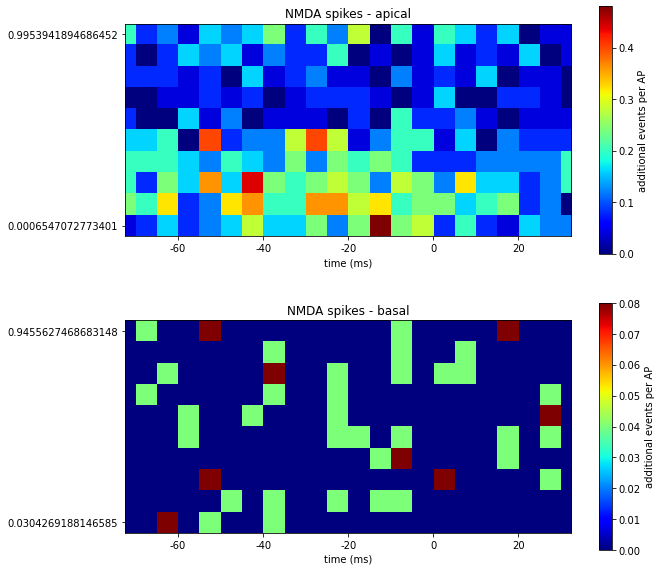

In [192]:
plt.figure(num=3,figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow((nmda_apic-nmda_apic_rand)/len(spktimes),cmap='jet')
# plt.imshow((nmda_apic-nmda_apic_rand)/len(spktimes),cmap='jet',vmin=-0.6,vmax=0.6)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.yticks(ticks=[0,9],labels=[str(segs_nmda_df[segs_nmda_df.Type=='apic']['Elec_distance'].max()),str(segs_nmda_df[segs_nmda_df.Type=='apic']['Elec_distance'].min())])
plt.colorbar(label='additional events per AP')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow((nmda_dend-nmda_dend_rand)/len(spktimes),cmap='jet')
# plt.imshow((nmda_dend-nmda_dend_rand)/len(spktimes),cmap='jet', vmin=-0.6, vmax=0.6)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.yticks(ticks=[0,9],labels=[str(segs_nmda_df[segs_nmda_df.Type=='dend']['Elec_distance'].max()),str(segs_nmda_df[segs_nmda_df.Type=='dend']['Elec_distance'].min())])
plt.colorbar(label='additional events per AP')
plt.xlim(5,26)

plt.xlabel('time (ms)')
if Detailed==True:
    plt.savefig(output_folder+'/DetailedNMDASpikes.png')
else:
    plt.savefig(output_folder+'/ReducedNMDASpikes.png')
plt.show(plt.figure(num=3)) #test

In [193]:
sum(segs_nmda_df['segmentID'][segs_nmda_df.Type=='dend'])

18429

In [194]:
segs.Type

0              soma
1              dend
2              dend
3              dend
4              dend
           ...     
983    passivebasal
984    passivebasal
985    passivebasal
986    passivebasal
987    passivebasal
Name: Type, Length: 988, dtype: object

/tmp/ipykernel_292381/3557799417.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))


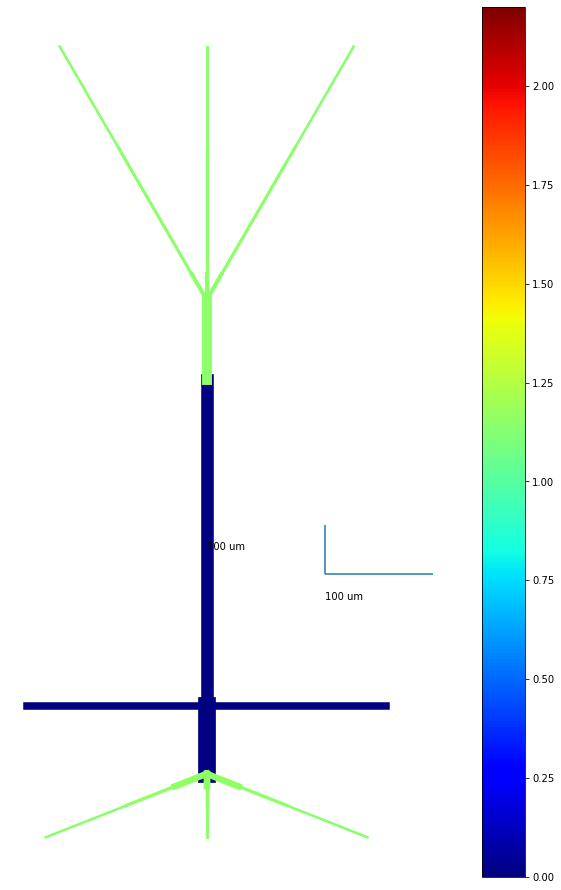

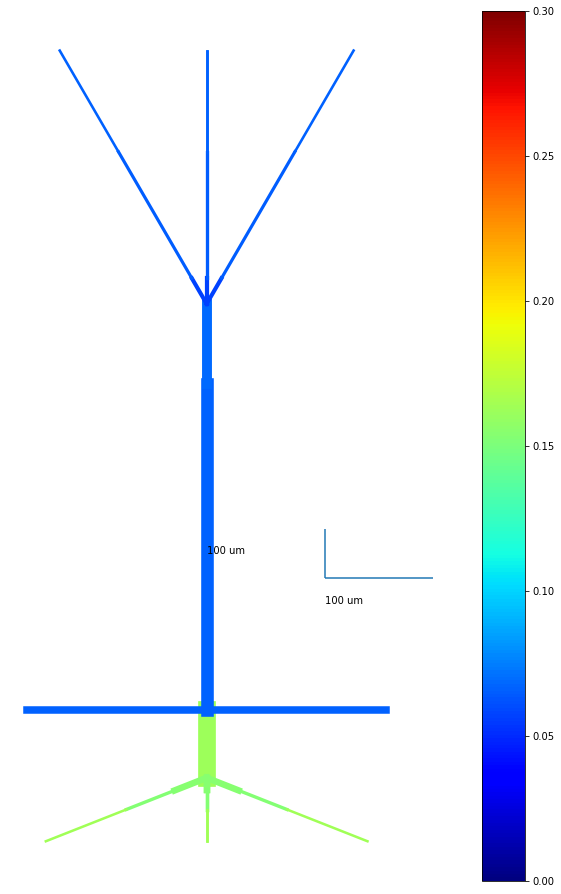

In [195]:
def plot_colorfield(color_field=str,vmin = None,vmax = None,lw=1):
    ax = plt.figure(figsize=(10,16))
    import matplotlib
    from matplotlib.colors import Normalize
    cmap = matplotlib.cm.get_cmap('jet')
    norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax)

    for i in segs[segs.Type=='apic']['Sec ID'].unique():
        section_L = segs[(segs.Type=='apic')&(segs['Sec ID']==i)]['Section_L'].unique()[0]
        plt.plot(segs[(segs.Type=='apic')&(segs['Sec ID']==i)]['Coord X'],
                segs[(segs.Type=='apic')&(segs['Sec ID']==i)]['Coord Y'],
                color=cmap(norm(segs[(segs.Type=='apic')&(segs['Sec ID']==i)][color_field].sum()/section_L)),
                linewidth = lw*segs[(segs.Type=='apic')&(segs['Sec ID']==i)]['Section_diam'].unique())
        
    for i in segs[segs.Type=='dend']['Sec ID'].unique():
        section_L = segs[(segs.Type=='dend')&(segs['Sec ID']==i)]['Section_L'].unique()[0]
        plt.plot(segs[(segs.Type=='dend')&(segs['Sec ID']==i)]['Coord X'],
                segs[(segs.Type=='dend')&(segs['Sec ID']==i)]['Coord Y'],
                color=cmap(norm(segs[(segs.Type=='dend')&(segs['Sec ID']==i)][color_field].sum()/section_L)),
                linewidth = lw*segs[(segs.Type=='dend')&(segs['Sec ID']==i)]['Section_diam'].unique())
    #    
    #
    plt.scatter(segs[(segs.Type=='soma')&(segs['Sec ID']==0)].loc[0,'Coord X'],
            segs[(segs.Type=='soma')&(segs['Sec ID']==0)].loc[0,'Coord Y'],color='k',s=100)
    plt.vlines(110,400,500)
    plt.text(0,450,'100 um')
    plt.hlines(400,110,210)
    plt.text(110,350,'100 um')
    plt.xticks([])
    plt.yticks([])
    cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
    #cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

    #ax2.ax.set_title('log(elec_distance)',rotation=270)
    plt.box(False)
    plt.savefig(output_folder+str(color_field)+'.png')

plot_colorfield(color_field='num_syns_exc',vmax=2.2,vmin=0,lw=5)
plot_colorfield(color_field='num_syns_inh',vmax=0.3,vmin=0,lw=5)

In [196]:
#NMDA effect on calcium
#ca_spktimes = segs_ca_df[segs_ca_df.segmentID==1738]['ca_lower_bound']/10
def get_nmda_sta_calcium(segs_nmda_df, spktimes):    
    nmda_dend = np.zeros((10,27,))
    nmda_apic = np.zeros((10,27,))
    
    edges_dend=np.quantile(segs_nmda_df[(segs_nmda_df.Type=='dend')]['Elec_distance_nexus'].unique(),np.arange(0,1.1,0.1))
    edges_apic=np.quantile(segs_nmda_df[(segs_nmda_df.Type=='apic')]['Elec_distance_nexus'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                     (segs_nmda_df.Type=='dend')&
                                     (segs_nmda_df.Elec_distance_nexus>edges_dend[e])&
                                     (segs_nmda_df.Elec_distance_nexus<=edges_dend[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_dend[e] += x2
                
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                     (segs_nmda_df.Type=='apic')&
                                     (segs_nmda_df.Elec_distance_nexus>edges_apic[e])&
                                     (segs_nmda_df.Elec_distance_nexus<=edges_apic[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
        
    return nmda_dend, nmda_apic
edges_apic=np.quantile(segs_nmda_df[(segs_nmda_df.Type=='apic')]['Elec_distance_nexus'].unique(),np.arange(0,1.1,0.1))


In [197]:
ca_spktimes = segs_ca_df[(segs_ca_df['Sec Name']=='disttrunk')]['ca_lower_bound']/10

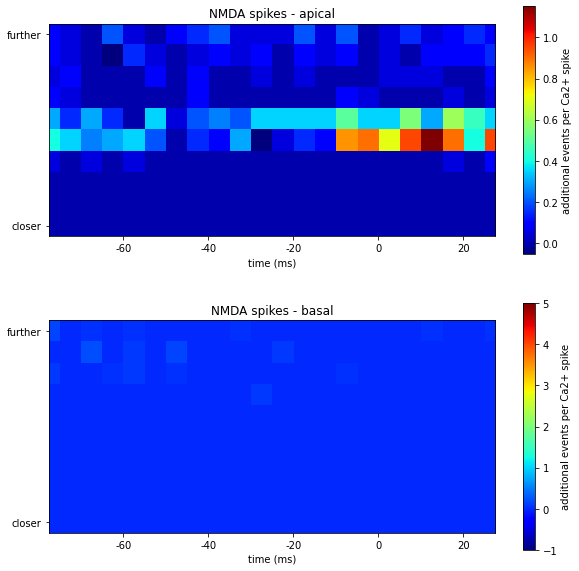

In [198]:
ca_spktimes_nodupes = np.sort(ca_spktimes[1:])[np.diff(np.sort(ca_spktimes))>100]
nmda_dend, nmda_apic = get_nmda_sta_calcium(segs_nmda_df,ca_spktimes_nodupes)
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), ca_spktimes_nodupes.shape[0]))
nmda_dend_rand, nmda_apic_rand = get_nmda_sta_calcium(segs_nmda_df, rand_spktimes)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
x = (nmda_apic-nmda_apic_rand)/ca_spktimes_nodupes.shape[0]
# plt.imshow(x,cmap='jet',vmin = -1, vmax = 5)
plt.imshow(x,cmap='jet',vmin = None, vmax = None)
plt.xticks(ticks=np.arange(0,26,4)+0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per Ca2+ spike')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
x = (nmda_dend-nmda_dend_rand)/ca_spktimes_nodupes.shape[0]
plt.imshow(x,cmap='jet',vmin = -1, vmax = 5)
plt.xticks(ticks=np.arange(0,26,4)+0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per Ca2+ spike')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.savefig(output_folder+'/nmdaspikes.png')
plt.show()

In [199]:
segs_nmda_df['Elec_distance_nexus']

0       1.000000
1       0.945563
2       0.847182
3       0.762211
4       0.689646
          ...   
1838    0.480345
1839    0.457455
1840    0.436492
1841    0.417239
1842    0.399504
Name: Elec_distance_nexus, Length: 1843, dtype: float64

In [200]:
# print(segs_nmda_df[segs_nmda_df['nmda_lower_bound']>8000]) #get every index where nmda_lower_bound>8000
# print(segs[segs['Seg_L']>5]) #show segs with this condition
totallength=sum(segs['Seg_L'])

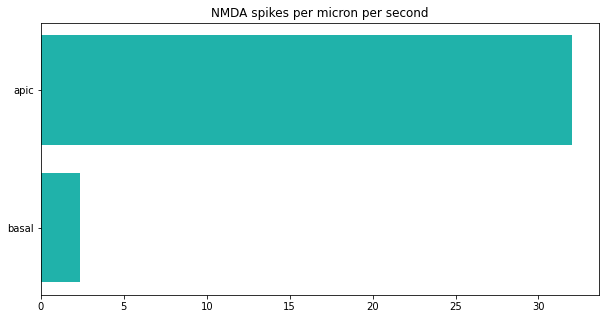

In [201]:
total_basal_nmda = sum(segs_nmda_df['segmentID'][segs_nmda_df.Type=='dend'][~pd.isnull(segs_nmda_df.mag)])
# num_basal_seg = len(segs[segs.Type=='dend'])
basal_length = sum(segs['Seg_L'][segs.Type=='dend'])

total_apic_nmda = sum(segs_nmda_df['segmentID'][segs_nmda_df.Type=='apic'][~pd.isnull(segs_nmda_df.mag)])
# num_apic_seg = len(segs[segs.Type=='apic'])
apic_length = sum(segs['Seg_L'][segs.Type=='apic'])

# apic_nmda_perSeg_perSec = (total_apic_nmda / num_apic_seg)/(tstop/dt)
# basal_ndma_perSeg_perSec = (total_basal_nmda / num_basal_seg)/(tstop/dt)
apic_nmda_perUM_perSec = (total_apic_nmda / apic_length)/(tstop/1000) # Can divide by x microns to get per X microns
basal_ndma_perUM_perSec = (total_basal_nmda / basal_length)/(tstop/1000) # Can divide by x microns to get per X microns

# data = {'basal':basal_ndma_perSeg_perSec, 'apic':apic_nmda_perSeg_perSec}
data = {'basal':basal_ndma_perUM_perSec, 'apic':apic_nmda_perUM_perSec}
group = list(data.keys())
value = list(data.values())

fig = plt.figure(figsize = (10, 5))
# plt.title('NMDA spikes per segment per second')
plt.title('NMDA spikes per micron per second')


# creating the bar plot
plt.barh(group, value, color ='lightseagreen')
if Detailed==True:
    plt.savefig(output_folder+'/DetailedNMDASpikesPerUmPerSec.png')
else:
    plt.savefig(output_folder+'/ReducedNMDASpikesPerUmPerSec.png')

In [202]:
total_basal_na = sum(segs_na_df['segmentID'][segs_na_df.Type=='dend'][~pd.isnull(segs_na_df.duration_high)])
# num_basal_seg = len(segs[segs.Type=='dend'])
basal_length = sum(segs['Seg_L'][segs.Type=='dend'])

total_apic_na = sum(segs_na_df['segmentID'][segs_na_df.Type=='apic'][~pd.isnull(segs_na_df.duration_high)])
# num_apic_seg = len(segs[segs.Type=='apic'])
apic_length = sum(segs['Seg_L'][segs.Type=='apic'])

# apic_na_perSeg_perSec = (total_apic_na / num_apic_seg)/(tstop/dt)
# basal_na_perSeg_perSec = (total_basal_na / num_basal_seg)/(tstop/dt)
apic_na_perUM_perSec = (total_apic_na / apic_length)/(tstop/1000) # Can divide by x microns to get per X microns
basal_na_perUM_perSec = (total_basal_na / basal_length)/(tstop/1000) # Can divide by x microns to get per X microns

# data = {'basal':basal_na_perSeg_perSec, 'apic':apic_na_perSeg_perSec}
data = {'basal':basal_na_perUM_perSec, 'apic':apic_na_perUM_perSec}
group = list(data.keys())
value = list(data.values())

fig = plt.figure(figsize = (10, 5))
# plt.title('Na spikes per segment per second')
plt.title('Na spikes per micron per second')


# creating the bar plot
plt.barh(group, value, color ='powderblue')
if Detailed==True:
    plt.savefig(output_folder+'/DetailedNASpikesPerUmPerSec.png')
else:
    plt.savefig(output_folder+'/ReducedNASpikesPerUmPerSec.png')

AttributeError: 'DataFrame' object has no attribute 'duration_high'

In [ ]:
total_basal_ca = sum(segs_ca_df['index'][segs_ca_df.Type=='dend'][~pd.isnull(segs_ca_df.duration_high)])
# num_basal_seg = len(segs[segs.Type=='dend'])
basal_length = sum(segs['Seg_L'][segs.Type=='dend'])

print(total_basal_ca)

total_apic_ca = sum(segs_ca_df['index'][segs_ca_df.Type=='apic'][~pd.isnull(segs_ca_df.duration_high)])
# num_apic_seg = len(segs[segs.Type=='apic'])
apic_length = sum(segs['Seg_L'][segs.Type=='apic'])

# apic_ca_perSeg_perSec = (total_apic_ca / num_apic_seg)(tstop/dt)
# basal_ca_perSeg_perSec = (total_basal_ca / num_basal_seg)(tstop/dt)

apic_ca_perUM_perSec = (total_apic_ca / apic_length)/(tstop/1000) # Can divide by x microns to get per X microns
basal_ca_perUM_perSec = (total_basal_ca / basal_length)/(tstop/1000) # Can divide by x microns to get per X microns


# data = {'basal':basal_ca_perSeg_perSec, 'apic':apic_ca_perSeg_perSec}
data = {'basal':basal_ca_perUM_perSec, 'apic':apic_ca_perUM_perSec}
group = list(data.keys())
value = list(data.values())

fig = plt.figure(figsize = (10, 5))

# plt.title('Calcium spikes per segment per second')
plt.title('Calcium spikes per UM per second')

 
# creating the bar plot
plt.barh(group, value, color ='tomato')

if Detailed==True:
    plt.savefig(output_folder+'/DetailedCaSpikesPerUmPerSec.png')
else:
    plt.savefig(output_folder+'/ReducedCaSpikesPerUmPerSec.png')

In [ ]:
# segs.head() # segs does not have number of spikes
# print(segs_ca_df)

In [ ]:
# segs_ca_df[~pd.isnull(segs_ca_df.duration_high)].head()
segs_ca_df.head()

In [ ]:
all_ca=pd.DataFrame()
all_ca['NumSpikes'] = segs_ca_df['index'][~pd.isnull(segs_ca_df.duration_high)]
# print(segs_ca_df[~pd.isnull(segs_ca_df.duration_high)])
print(all_ca) # segment id and number of spikes
# print(sum(all_ca))
# plt.figure(figsize=(4,10))
# ax = plt.scatter(segs['Coord X'], segs['Coord Y'],c=all_ca)
# plt.vlines(110,400,500)
# plt.text(0,450,'100 um')
# plt.hlines(400,110,210)
# plt.text(110,350,'100 um')
# plt.xticks([])
# plt.yticks([])
# cbar = plt.colorbar()
# cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

# #ax2.ax.set_title('log(elec_distance)',rotation=270)
# plt.box(False)
# plt.savefig('Elec_distance.png')
# # all_ca_perUM_perSec = (all_ca / segs['Seg_L'])/(tstop/dt) # Can divide by x microns to get per X microns
# # # print(all_ca_perUM_perSec)
# # for i in range(len(all_ca_perUM_perSec)):
# #     if np.isnan(all_ca_perUM_perSec[i])==True:
# #         all_ca_perUM_perSec[i]=0
# # print(all_ca_perUM_perSec)

In [ ]:
for i in np.arange(0,10):
    plt.plot(np.arange(-40,95,5),nmda_dend[i]/np.sum(nmda_dend[i]))


In [ ]:
# segs_conns[(segs_conns['Sec ID']==80) & (segs_conns.Type=='dend')]['Source Population'].value_counts()

In [ ]:
plt.figure(figsize=(10,10))
ind = 55
plt.plot(segs['Coord X'], segs['Coord Y'], 'b.')
plt.plot(segs.loc[0,'Coord X'], segs.loc[0,'Coord Y'], 'k.',markersize=20)

plt.plot(segs.loc[ind,'Coord X'], segs.loc[ind,'Coord Y'], 'r*',markersize=20)

# for i in segs_conns[(segs_conns.Type=='dend')&(segs_conns['Sec ID']==2)]['Sec ID'].unique():
#     plt.plot(segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord X'],
#              segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord Y'],color='r')
    
#for i in segs_conns[(segs_conns.Type=='dend')&(segs_conns['Sec ID']==7)]['Sec ID'].unique():
#    plt.plot(segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord X'],
#             segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord Y'],color='c')
    
#plt.plot(segs[segs.segmentID==119]['Coord X'], segs[segs.segmentID==119]['Coord Y'],'r*',markersize=14)
#plt.plot(segs[segs.segmentID==110]['Coord X'], segs[segs.segmentID==110]['Coord Y'],'r*',markersize=14)
#plt.plot(segs[segs.segmentID==103]['Coord X'], segs[segs.segmentID==103]['Coord Y'],'r*',markersize=14)

#plt.plot(segs[segs.segmentID==134]['Coord X'], segs[segs.segmentID==134]['Coord Y'],'c*',markersize=14)
plt.ylim(-25,50)
plt.xlim(-150,150)

In [ ]:
# plt.figure(figsize=(10,10))
# plt.plot(f['report']['biophysical']['data'][:,119],color='b')
# plt.plot(f['report']['biophysical']['data'][:,110],color='b',alpha=0.5)
# plt.plot(f['report']['biophysical']['data'][:,104],color='b',alpha=0.1)

# plt.plot(f['report']['biophysical']['data'][:,134],color='c',alpha=1)
# plt.plot(f['report']['biophysical']['data'][:,0],'k')
# plt.twinx()
# plt.plot(h['report']['biophysical']['data'][:,119],color='r')
# plt.plot(h['report']['biophysical']['data'][:,110],color='r',alpha=0.5)
# plt.plot(h['report']['biophysical']['data'][:,103],color='r',alpha=0.1)

# plt.xlim(526519-100,526519+1000)

In [ ]:
nmda2 = np.zeros((79,))
try:
  for i in spktimes:
      nmda_inds2 = np.sort(segs_nmda_df[(segs_nmda_df.Degrees<=3)&
              (~pd.isnull(segs_nmda_df.nmda_lower_bound))&
              (segs_nmda_df.mag<-0.1)&
                  (segs_nmda_df.Type=='dend')]['nmda_lower_bound'].values.astype(int))

      x2, _ = np.histogram(nmda_inds2/10,bins=np.arange(i-40,i+40,1))
      nmda2 += x2
except:
  print('segs_nmda_df "DataFrame" object has no attribute "Degrees"')
    
    #na_inds3 = segs_na_df[(segs_na_df.Degrees==3)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x3, _ = np.histogram(na_inds3/10,bins=np.arange(i-20,i+20,1))
    #na3 += x3
    
    #na_inds4 = segs_na_df[(segs_na_df.Degrees==4)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x4, _ = np.histogram(na_inds4/10,bins=np.arange(i-20,i+20,1))
    #na4 += x4
    
    #na_inds5 = segs_na_df[(segs_na_df.Degrees==5)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x5, _ = np.histogram(na_inds5/10,bins=np.arange(i-20,i+20,1))
    #na5 += x5
    

In [ ]:
plt.plot(nmda2)

In [ ]:
segs_ca_df.head()
# segs_na_df.head()
# segs_nmda_df.head()

In [ ]:
segs.head()

In [ ]:
#calculate segment spikes per second


In [ ]:
# import matplotlib
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 16}

# matplotlib.rc('font', **font)

# ind = 1139
# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,ind],color='b',label='dend voltage')
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,0],color='k',alpha=0.3,label='soma voltage')
# plt.legend(loc='lower left')
# plt.hlines(-40,0,60000,linestyle='dashed')
# plt.ylabel('voltage (mV)')
# plt.ylim(-85,25)
# plt.xlabel('time (ms)')
# plt.twinx()
# plt.plot(np.arange(0,60000,.1),h['report']['biophysical']['data'][:,ind],color='r',label='inmda dend')
# plt.legend(loc='upper right')
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==ind]['nmda_lower_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==ind]['nmda_lower_bound'].values.astype(int),ind],'m*',markersize=20)
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==ind]['nmda_upper_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==ind]['nmda_upper_bound'].values.astype(int),ind],'k*',markersize=20)
# plt.ylim(-0.009,0.001)
# plt.xlim(37000,39000)
# plt.ylabel('current (nA)')


In [ ]:
# import matplotlib
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 16}

# matplotlib.rc('font', **font)

# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,175],color='b',label='dend voltage')
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,0],color='k',alpha=0.3,label='soma voltage')
# plt.legend(loc='lower left')
# plt.hlines(-40,0,60000,linestyle='dashed')
# plt.ylabel('voltage (mV)')
# plt.ylim(-85,25)
# plt.xlabel('time (ms)')
# plt.twinx()
# plt.plot(np.arange(0,60000,.1),h['report']['biophysical']['data'][:,175],color='r',label='inmda dend')
# plt.legend(loc='upper right')
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==175]['nmda_lower_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==175]['nmda_lower_bound'].values.astype(int),175],'m*',markersize=20)
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==175]['nmda_upper_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==175]['nmda_upper_bound'].values.astype(int),175],'k*',markersize=20)
# plt.xlim(32000,32400)
# plt.ylim(-0.009,0.001)
# plt.ylabel('current (nA)')


In [ ]:
nmda_spktimes = nmda_df[nmda_df.mag<-0.1]['nmda_lower_bound']/10
n = np.zeros((12,))
for i in spktimes:
    x,y = np.histogram(nmda_spktimes[(nmda_spktimes>i-30) & (nmda_spktimes<i+30)]-i,bins=np.arange(-30,31,5))
    n+=x

In [ ]:
np.arange(-30,31,5).shape

In [ ]:
plt.plot(np.arange(-30,30,5),n)

In [ ]:
na_spktimes = na_df[~pd.isnull(na_df.na_lower_bound)]['na_lower_bound']/10
na = np.zeros((20,))
for i in spktimes:
    x,y = np.histogram(na_spktimes[(na_spktimes>i-10) & (na_spktimes<i+10)]-i,bins=np.arange(-10,11,1))
    na+=x

In [ ]:
# plt.plot(na_df[~pd.isnull(na_df.na_lower_bound)]['na_lower_bound']/10,
#          na_df[~pd.isnull(na_df.na_lower_bound)]['seg_id'],'*')

In [ ]:
plt.plot(nmda_spktimes,np.random.randint(low=0,high=100,size=len(nmda_spktimes)),'.')
plt.plot(spktimes,np.tile(40,len(spktimes)),'r*')

In [ ]:
x1,_=np.histogram(spktimes,bins=np.arange(0,10000,100))
x2,_=np.histogram(nmda_spktimes,bins=np.arange(0,10000,100))

In [ ]:
# plt.figure(figsize=(10,8))
# plt.plot(np.arange(0,10000,.1),control_v[:,176],color='b')
# plt.plot(np.arange(0,10000,.1)[nmda_df.loc[nmda_df.seg_id==175,'nmda_lower_bound'].values.astype(int)],control_v[nmda_df.loc[nmda_df.seg_id==175,'nmda_lower_bound'].values.astype(int),176],'m*')
# plt.plot(np.arange(0,10000,.1),control_v[:,0],color='k')
# plt.xlim(6000,7000)

In [ ]:
# # ind1 = 3 sent to Drew
# ind1 = 2
# e1 = control_inmda[legit_uc_iso[ind1], p]
# e2 = control_inmda[legit_dc_iso[ind1], p]
# x30 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.3*e1, prepend=False))
# x15 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.15*e1, prepend=False))

In [ ]:
# import matplotlib
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 16}

# matplotlib.rc('font', **font)

# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
#          control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p],color='r',label='inmda @ dend.')
# plt.hlines(1.3*e1,0,np.max(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1)),color='r',alpha=0.2)
# plt.hlines(1.15*e1,0,np.max(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1)),color='r',alpha=0.2)
# plt.ylabel('current (nA)')
# plt.ylim(-0.010,0)
# plt.legend(loc='upper center')
# plt.xlabel('time (ms)')
# plt.twinx()
# plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
#          control_v[legit_uc_iso[ind1]:legit_dc_iso[ind1],p],color='b',label='dend. volt.')
# plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
#          control_v[legit_uc_iso[ind1]:legit_dc_iso[ind1],0], color='k',label='soma volt.')


# for i in np.arange(0,len(bounds)):
#     plt.fill_between(np.array([bounds[i][0]/10,bounds[i][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
#     plt.text(bounds[i][0]/10,-20-(i*10),'{x:.2f}'.format(x=sum_current[i]))
##plt.fill_between(np.array([bounds[1][0]/10,bounds[1][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
##plt.fill_between(np.array([bounds[2][0]/10,bounds[2][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
#plt.hlines(-40,0,np.max(np.arange(0,(legit_uc_iso[ind1+1]-legit_uc_iso[ind1])/10, 0.1)),linestyle='dashed')
##plt.text(1.5,14,'NMDA\nspike')
#plt.ylabel('voltage (mV)')
#plt.legend()

In [ ]:
# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,10000,.1),control_v[:,p],label='control dend. v')
# plt.plot(np.arange(0,10000,.1),NMDAblock_v[:,p],label='NMDA block dend. v')
# plt.plot(np.arange(0,10000,.1),control_v[:,0],color='k',label='control soma v')

# uc = voltage_criterion(control_v[:,p],-40)[0]


# plt.plot(np.arange(0,10000,.1)[uc],control_v[uc,p],'*')
# plt.plot(np.arange(0,10000,.1)[legit_uc],control_v[legit_uc,p],'m*')


# center = np.floor(legit_uc[np.random.choice(np.arange(0,legit_uc.shape[0]))]/10)

# plt.plot([center,center+26],[-80,-80],color='k')
# plt.legend(loc='lower left')

# plt.twinx()
# plt.plot(np.arange(0,10000,.1),control_inmda[:,p],color='r',label='NMDA current')
# plt.plot(np.arange(0,10000,.1)[legit_uc],control_inmda[legit_uc, p],'*')
# #plt.plot(np.arange(0,10000,.1),control_gna[:,p],color='r',alpha=0.2, label='gNa')
# plt.xlim(center-100,center+100)

# plt.legend(loc='lower right')
# plt.title('{}'.format(legit_uc))

In [ ]:
# p = np.random.choice(segs[segs.Type=='apic'].index)
# for i in spktimes:
#     plt.plot(np.arange(0,20,.1), control_v[int(i*10)-100:int(i*10)+100,p])
# plt.vlines(10,-65,0,color='k')
# plt.ylim(-65,0)

In [ ]:
# p = 829#np.random.choice(segs[segs.Type=='dend'].index)
# plt.title('dend {}'.format(p))
# plt.plot(control_v[7200:7700,p],label='dend')
# plt.plot(control_v[7200:7700,0],label='soma')
# plt.hlines(-40,0,500)
# plt.twinx()
# plt.plot(control_inmda[7200:7700,p],color='r')
# plt.legend()

In [ ]:
# control_v[10000,0]

In [ ]:
# plt.hist(control_v[10000,:])

In [ ]:
# plt.plot(control_v[:,1200])
# plt.plot(NMDAblock_v[:,1200])

In [ ]:
# df = ids_pos.set_index(['BMTK ID', 'X']).join(segs.set_index(['BMTK ID', 'X'])).reset_index()

In [ ]:
# df.loc[0,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[0]

In [ ]:
# df[(df.Distance>900) & (df.Distance<1000)]

In [ ]:
# plt.scatter(np.arange(0,df.shape[0]), np.mean(f['report']['biophysical']['data'],axis=0))
# plt.xlim(1740,1760)

In [ ]:
# plt.figure(figsize=(10,6))
# plt.scatter(df['Elec_distance'],np.mean(f['report']['biophysical']['data'],axis=0),alpha=0.2)
# plt.scatter(df.loc[0,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[0],color='r', marker='*', s=75)
# plt.scatter(df.loc[1452,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[1452],color='m',marker='*', s=75)
# plt.scatter(df.loc[1754,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[1754],color='k',marker='*', s=75)
# plt.xlabel('distance from soma')
# plt.ylabel('mean potential of segment (mV)')

In [ ]:
# #plt.scatter(np.arange(0,f['report']['biophysical']['data'].shape[1]),np.mean(f['report']['biophysical']['data'],axis=0))

# plt.figure(figsize=(10,6))

# plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,0],color='r')
# plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,1452],color='m')
# plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,1754],color='k')
# plt.xlim(1.75,2)
# plt.xlabel('time (s)')
# plt.ylabel('membrane potential (mV)')